In [17]:
import numpy as np
import cv2
from matplotlib.pyplot import plot
from pathlib import Path
from itertools import combinations
import utils
from utils import to_homo

In [2]:
DATA_ROOT_PATH = Path('data')
IMG_PATH =  DATA_ROOT_PATH / 'q3.png'
ANNOTATIONS_PATH = DATA_ROOT_PATH / 'q3' / 'q3.npy'

COLORS = [(0, 255, 0), (0, 255, 255), (255, 255, 0), (255, 0, 0), (0, 0, 255)]

In [3]:
image = utils.load_image(IMG_PATH)

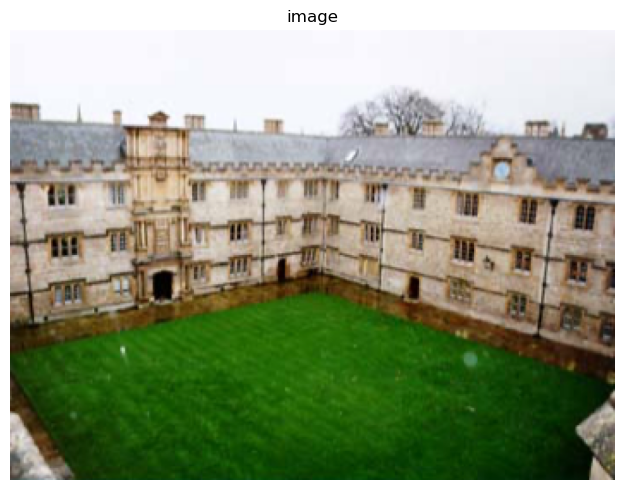

In [4]:
utils.show_images([image], ['image'])

In [7]:
annotations = np.load(ANNOTATIONS_PATH)

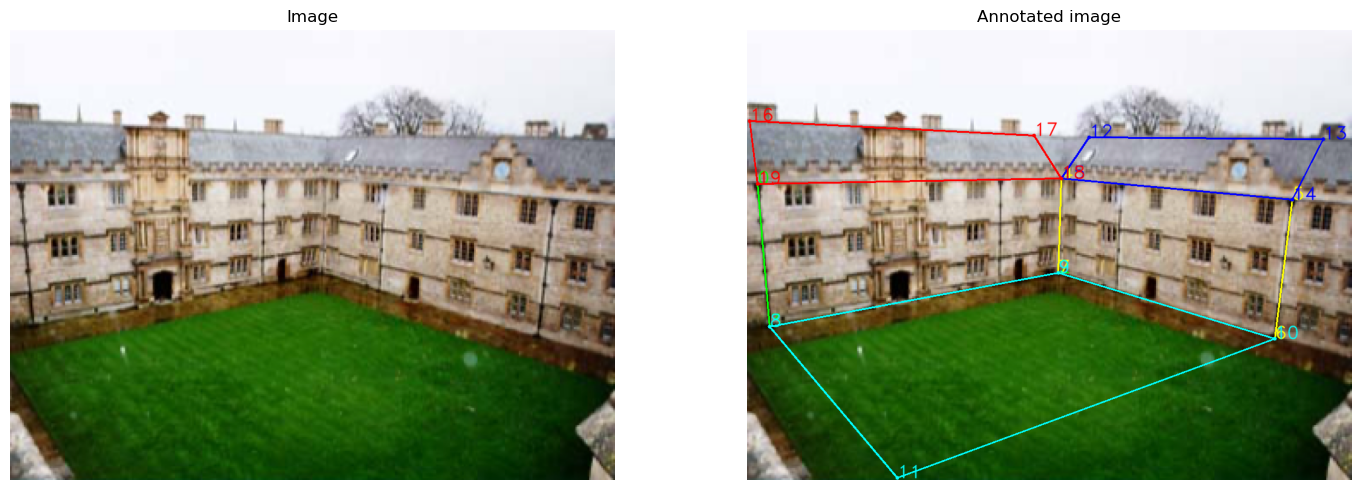

In [8]:
annotated_img = image.copy()

for i in range(annotations.shape[0]):
    COLOR = COLORS[i]
    square = annotations[i]
    for j in range(square.shape[0]):
        x, y = square[j]
        cv2.circle(annotated_img, (x, y), 3, COLOR, -1)
        cv2.putText(
            annotated_img,
            str(j + i * 4),
            (x, y),
            cv2.FONT_HERSHEY_DUPLEX,
            1,
            COLOR,
            1,
            cv2.LINE_AA,
        )
        cv2.line(annotated_img, square[j], square[(j + 1) % 4], COLOR, 2)
    
utils.show_images([image, annotated_img], ['Image', 'Annotated image'])

In [9]:
print(annotations)
annotations.shape

[[[ 17 254]
  [519 245]
  [514 401]
  [ 37 490]]

 [[519 245]
  [901 280]
  [872 510]
  [514 401]]

 [[ 37 490]
  [514 401]
  [872 510]
  [248 740]]

 [[565 177]
  [952 180]
  [901 280]
  [519 245]]

 [[  4 150]
  [474 174]
  [519 245]
  [ 17 254]]]


(5, 4, 2)

In [13]:
planes = np.array([annotations[0, :, :], annotations[2, :, :]])
planes.shape

(2, 4, 2)

In [20]:
lines = []        

line = np.cross(to_homo(planes[0][0]), to_homo(planes[0][1]))
line = line / line[-1]
lines.append(line)
        
line = np.cross(to_homo(planes[0][2]), to_homo(planes[0][3]))
line = line / line[-1]
lines.append(line)

line = np.cross(to_homo(planes[0][0]), to_homo(planes[0][3]))
line = line / line[-1]
lines.append(line)

line = np.cross(to_homo(planes[0][1]), to_homo(planes[0][2]))
line = line / line[-1]
lines.append(line)

line = np.cross(to_homo(planes[1][0]), to_homo(planes[1][3]))
line = line / line[-1]
lines.append(line)

line = np.cross(to_homo(planes[1][1]), to_homo(planes[1][2]))
line = line / line[-1]
lines.append(line)

v_points = []

for i in range(0, len(lines), 2):
    v_point = np.cross(lines[i], lines[i + 1])
    v_point = v_point / v_point[-1]

    v_points.append(v_point)

v_pairs = list(combinations(v_points, 2))
print(v_points)
print(v_pairs)

[array([1.43843628e+03, 2.28516083e+02, 1.00000000e+00]), array([3.81032558e+02, 4.54958419e+03, 1.00000000e+00]), array([-229.06223967,  174.76037954,    1.        ])]
[(array([1.43843628e+03, 2.28516083e+02, 1.00000000e+00]), array([3.81032558e+02, 4.54958419e+03, 1.00000000e+00])), (array([1.43843628e+03, 2.28516083e+02, 1.00000000e+00]), array([-229.06223967,  174.76037954,    1.        ])), (array([3.81032558e+02, 4.54958419e+03, 1.00000000e+00]), array([-229.06223967,  174.76037954,    1.        ]))]


In [22]:
# Constract the A matrix Aw = 0
A = []

for vp in v_pairs:
    xi = vp[0][0]
    yi = vp[0][1]
    xj = vp[1][0]
    yj = vp[1][1]

    equ = [xi * xj + yi * yj, xi + xj, yi + yj, 1]
    A.append(equ)

_, _, vt = np.linalg.svd(A)
W =  vt[-1]
W = W / W[-1]

W = [
        [W[0], 0, W[1]],
        [0, W[0], W[2]],
        [W[1], W[2], W[3]]
    ]

W

[[9.45322726917892e-07, 0, -0.00048796246961713613],
 [0, 9.45322726917892e-07, -0.00033760241307703584],
 [-0.00048796246961713613, -0.00033760241307703584, 1.0]]

In [23]:
L = np.linalg.cholesky(W)
K = np.linalg.inv(L).T
K = K / K[2, 2]
K

array([[814.77013455,   0.        , 516.18611901],
       [ -0.        , 814.77013455, 357.12926757],
       [ -0.        ,   0.        ,   1.        ]])